###### Targets:
	- > 99.4+ & also a consistently higher accuracies.
	- There will be no increase in the total params as compared to previous attempts. Total 
	  params in all these attempts has to be under 10K.

###### Results (5th Attempt):
	- max Validation Accuracy reached: ~99.44%
	- max Train Accuracy reached: ~98.86%
	- Total params: 9,736
  
##### Analysis:
	- We observe a more consistent 99.3+% performance, with validation accuracy finally reaching 99.44%
	- The rotation image augmentation in a separate investigation didn't help in this case, hence didn't use it.


# Import Libraries

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
L1 = False
L2 = True

In [3]:
class_names  = [ "zero",  # index 0
                 "one",   # index 1
                 "two",   # index 2 
                 "three", # index 3 
                 "four",  # index 4
                 "five",  # index 5
                 "six",   # index 6 
                 "seven", # index 7 
                 "eight", # index 8 
                 "nine"]  # index 9

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_mnist, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_mnist, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


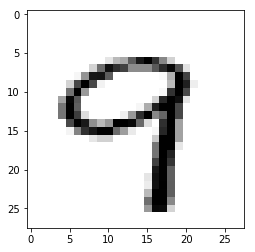

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_mnist.train_data
train_data = train_mnist.transform(train_data.numpy())
#train_data = train.train_data.cpu().numpy()

print('[Train]')
print(' - Numpy Shape:', train_mnist.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_mnist.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

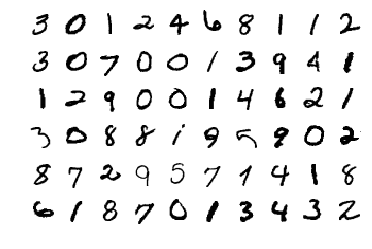

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [9]:
l1_weight = 0.01

In [10]:
l2_weight_decay = 0.1

In [11]:
dropout_value = 0.1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
model1 =  Net1().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader)

EPOCH: 0


Loss=1.3781788349151611 Batch_id=937 Accuracy=56.87: 100%|███████████████████████████| 938/938 [00:16<00:00, 55.65it/s]



Test set: Average loss: 1.2429, Accuracy: 6040/10000 (60.40%)

EPOCH: 1


Loss=1.2445310354232788 Batch_id=937 Accuracy=62.00: 100%|███████████████████████████| 938/938 [00:17<00:00, 56.39it/s]



Test set: Average loss: 1.3317, Accuracy: 5559/10000 (55.59%)

EPOCH: 2


Loss=1.344144582748413 Batch_id=937 Accuracy=67.32: 100%|████████████████████████████| 938/938 [00:18<00:00, 50.49it/s]



Test set: Average loss: 1.1991, Accuracy: 6532/10000 (65.32%)

EPOCH: 3


Loss=1.120640754699707 Batch_id=937 Accuracy=66.79: 100%|████████████████████████████| 938/938 [00:20<00:00, 45.97it/s]



Test set: Average loss: 1.1729, Accuracy: 5699/10000 (56.99%)

EPOCH: 4


Loss=1.1142457723617554 Batch_id=937 Accuracy=67.10: 100%|███████████████████████████| 938/938 [00:19<00:00, 49.32it/s]



Test set: Average loss: 1.1853, Accuracy: 6245/10000 (62.45%)

EPOCH: 5


Loss=1.1186223030090332 Batch_id=937 Accuracy=71.59: 100%|███████████████████████████| 938/938 [00:19<00:00, 60.36it/s]



Test set: Average loss: 1.1835, Accuracy: 7150/10000 (71.50%)

EPOCH: 6


Loss=1.153377652168274 Batch_id=937 Accuracy=72.96: 100%|████████████████████████████| 938/938 [00:17<00:00, 61.87it/s]



Test set: Average loss: 1.3077, Accuracy: 6560/10000 (65.60%)

EPOCH: 7


Loss=1.099942684173584 Batch_id=937 Accuracy=72.16: 100%|████████████████████████████| 938/938 [00:20<00:00, 45.72it/s]



Test set: Average loss: 1.0660, Accuracy: 6798/10000 (67.98%)

EPOCH: 8


Loss=1.1536298990249634 Batch_id=937 Accuracy=72.44: 100%|███████████████████████████| 938/938 [00:20<00:00, 46.36it/s]



Test set: Average loss: 1.1060, Accuracy: 7309/10000 (73.09%)

EPOCH: 9


Loss=1.1211376190185547 Batch_id=937 Accuracy=72.32: 100%|███████████████████████████| 938/938 [00:20<00:00, 45.50it/s]



Test set: Average loss: 1.0802, Accuracy: 6729/10000 (67.29%)

EPOCH: 10


Loss=1.230743408203125 Batch_id=937 Accuracy=71.71: 100%|████████████████████████████| 938/938 [00:18<00:00, 51.92it/s]



Test set: Average loss: 1.2532, Accuracy: 6883/10000 (68.83%)

EPOCH: 11


Loss=1.2518211603164673 Batch_id=937 Accuracy=72.30: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.57it/s]



Test set: Average loss: 1.2249, Accuracy: 6511/10000 (65.11%)

EPOCH: 12


Loss=1.042072057723999 Batch_id=937 Accuracy=72.88: 100%|████████████████████████████| 938/938 [00:18<00:00, 49.91it/s]



Test set: Average loss: 1.2952, Accuracy: 6252/10000 (62.52%)

EPOCH: 13


Loss=1.0847285985946655 Batch_id=937 Accuracy=71.80: 100%|███████████████████████████| 938/938 [00:18<00:00, 58.15it/s]



Test set: Average loss: 1.1097, Accuracy: 7251/10000 (72.51%)

EPOCH: 14


Loss=1.257699728012085 Batch_id=937 Accuracy=72.10: 100%|████████████████████████████| 938/938 [00:18<00:00, 57.29it/s]



Test set: Average loss: 1.2138, Accuracy: 7181/10000 (71.81%)

EPOCH: 15


Loss=1.2300477027893066 Batch_id=937 Accuracy=73.04: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.10it/s]



Test set: Average loss: 1.2117, Accuracy: 6958/10000 (69.58%)

EPOCH: 16


Loss=1.039137601852417 Batch_id=937 Accuracy=72.53: 100%|████████████████████████████| 938/938 [00:17<00:00, 58.97it/s]



Test set: Average loss: 1.2176, Accuracy: 7007/10000 (70.07%)

EPOCH: 17


Loss=1.1358060836791992 Batch_id=937 Accuracy=71.74: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.72it/s]



Test set: Average loss: 1.2513, Accuracy: 6640/10000 (66.40%)

EPOCH: 18


Loss=1.1488769054412842 Batch_id=937 Accuracy=72.26: 100%|███████████████████████████| 938/938 [00:18<00:00, 58.05it/s]



Test set: Average loss: 1.2255, Accuracy: 6685/10000 (66.85%)

EPOCH: 19


Loss=1.0347217321395874 Batch_id=937 Accuracy=71.92: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.18it/s]



Test set: Average loss: 1.1355, Accuracy: 6374/10000 (63.74%)



Text(0.5, 1.0, 'Test Accuracy')

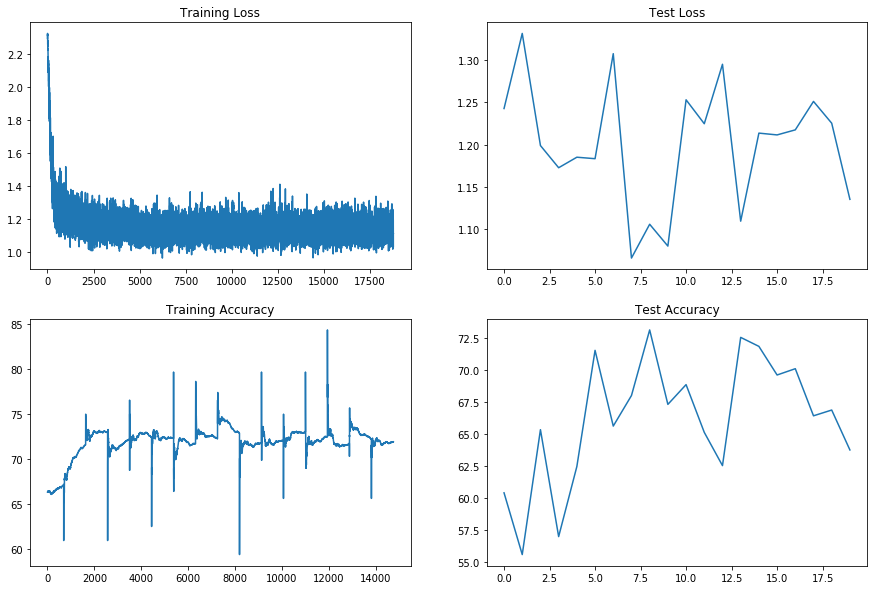

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.001

In [10]:
l2_weight_decay = 0.01

In [11]:
dropout_value = 0.1
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model2 =  Net2().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer, epoch)
    test(model2, device, test_loader)

EPOCH: 0


Loss=0.11874978989362717 Batch_id=937 Accuracy=86.62: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.09it/s]



Test set: Average loss: 0.1336, Accuracy: 9790/10000 (97.90%)

EPOCH: 1


Loss=0.198076069355011 Batch_id=937 Accuracy=96.71: 100%|████████████████████████████| 938/938 [00:17<00:00, 55.14it/s]



Test set: Average loss: 0.1452, Accuracy: 9675/10000 (96.75%)

EPOCH: 2


Loss=0.3549177348613739 Batch_id=937 Accuracy=96.80: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.24it/s]



Test set: Average loss: 0.1401, Accuracy: 9701/10000 (97.01%)

EPOCH: 3


Loss=0.10635437816381454 Batch_id=937 Accuracy=96.81: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.00it/s]



Test set: Average loss: 0.0973, Accuracy: 9832/10000 (98.32%)

EPOCH: 4


Loss=0.2275640368461609 Batch_id=937 Accuracy=96.83: 100%|███████████████████████████| 938/938 [00:17<00:00, 62.53it/s]



Test set: Average loss: 0.1753, Accuracy: 9570/10000 (95.70%)

EPOCH: 5


Loss=0.325112521648407 Batch_id=937 Accuracy=96.89: 100%|████████████████████████████| 938/938 [00:18<00:00, 51.94it/s]



Test set: Average loss: 0.1490, Accuracy: 9652/10000 (96.52%)

EPOCH: 6


Loss=0.14754197001457214 Batch_id=937 Accuracy=96.91: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.56it/s]



Test set: Average loss: 0.1075, Accuracy: 9807/10000 (98.07%)

EPOCH: 7


Loss=0.31116408109664917 Batch_id=937 Accuracy=96.79: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.50it/s]



Test set: Average loss: 0.0881, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.2494337409734726 Batch_id=937 Accuracy=96.95: 100%|███████████████████████████| 938/938 [00:18<00:00, 61.18it/s]



Test set: Average loss: 0.0906, Accuracy: 9827/10000 (98.27%)

EPOCH: 9


Loss=0.16810975968837738 Batch_id=937 Accuracy=96.83: 100%|██████████████████████████| 938/938 [00:17<00:00, 60.82it/s]



Test set: Average loss: 0.0965, Accuracy: 9818/10000 (98.18%)

EPOCH: 10


Loss=0.13829763233661652 Batch_id=937 Accuracy=96.89: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.86it/s]



Test set: Average loss: 0.1217, Accuracy: 9702/10000 (97.02%)

EPOCH: 11


Loss=0.12083297967910767 Batch_id=937 Accuracy=96.98: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.41it/s]



Test set: Average loss: 0.1281, Accuracy: 9712/10000 (97.12%)

EPOCH: 12


Loss=0.34551721811294556 Batch_id=937 Accuracy=96.84: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.03it/s]



Test set: Average loss: 0.1422, Accuracy: 9679/10000 (96.79%)

EPOCH: 13


Loss=0.09441954642534256 Batch_id=937 Accuracy=96.85: 100%|██████████████████████████| 938/938 [00:17<00:00, 59.96it/s]



Test set: Average loss: 0.1063, Accuracy: 9757/10000 (97.57%)

EPOCH: 14


Loss=0.3518519699573517 Batch_id=937 Accuracy=96.93: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.29it/s]



Test set: Average loss: 0.1381, Accuracy: 9660/10000 (96.60%)



Text(0.5, 1.0, 'Test Accuracy')

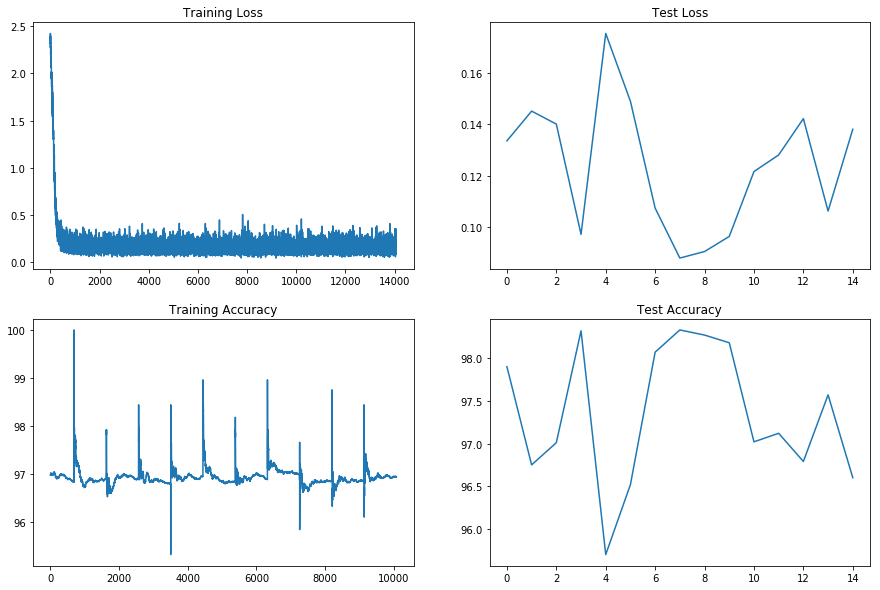

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.0001

In [10]:
l2_weight_decay = 0.001

In [11]:
dropout_value = 0.1
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model3 = Net3().to(device)
summary(model3, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model3 =  Net3().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model3, device, train_loader, optimizer, epoch)
    test(model3, device, test_loader)

EPOCH: 0


Loss=0.08482131361961365 Batch_id=937 Accuracy=87.14: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.68it/s]



Test set: Average loss: 0.0794, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.14238609373569489 Batch_id=937 Accuracy=97.36: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.39it/s]



Test set: Average loss: 0.0579, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


Loss=0.18415990471839905 Batch_id=937 Accuracy=97.82: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.57it/s]



Test set: Average loss: 0.0485, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.02042028307914734 Batch_id=937 Accuracy=98.02: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.61it/s]



Test set: Average loss: 0.0399, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.08494069427251816 Batch_id=937 Accuracy=98.14: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.93it/s]



Test set: Average loss: 0.0472, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.02309119701385498 Batch_id=937 Accuracy=98.21: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.10it/s]



Test set: Average loss: 0.0381, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.056916095316410065 Batch_id=937 Accuracy=98.26: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.33it/s]



Test set: Average loss: 0.0339, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.09910514205694199 Batch_id=937 Accuracy=98.32: 100%|██████████████████████████| 938/938 [00:18<00:00, 53.86it/s]



Test set: Average loss: 0.0340, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.16612248122692108 Batch_id=937 Accuracy=98.30: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.49it/s]



Test set: Average loss: 0.0400, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


Loss=0.02343650907278061 Batch_id=937 Accuracy=98.39: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.58it/s]



Test set: Average loss: 0.0373, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.04018732160329819 Batch_id=937 Accuracy=98.36: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.84it/s]



Test set: Average loss: 0.0324, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.018492907285690308 Batch_id=937 Accuracy=98.53: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.69it/s]



Test set: Average loss: 0.0388, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.15612787008285522 Batch_id=937 Accuracy=98.33: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.54it/s]



Test set: Average loss: 0.0317, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.08290817588567734 Batch_id=937 Accuracy=98.48: 100%|██████████████████████████| 938/938 [00:17<00:00, 61.13it/s]



Test set: Average loss: 0.0348, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.09705027937889099 Batch_id=937 Accuracy=98.47: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.28it/s]



Test set: Average loss: 0.0383, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

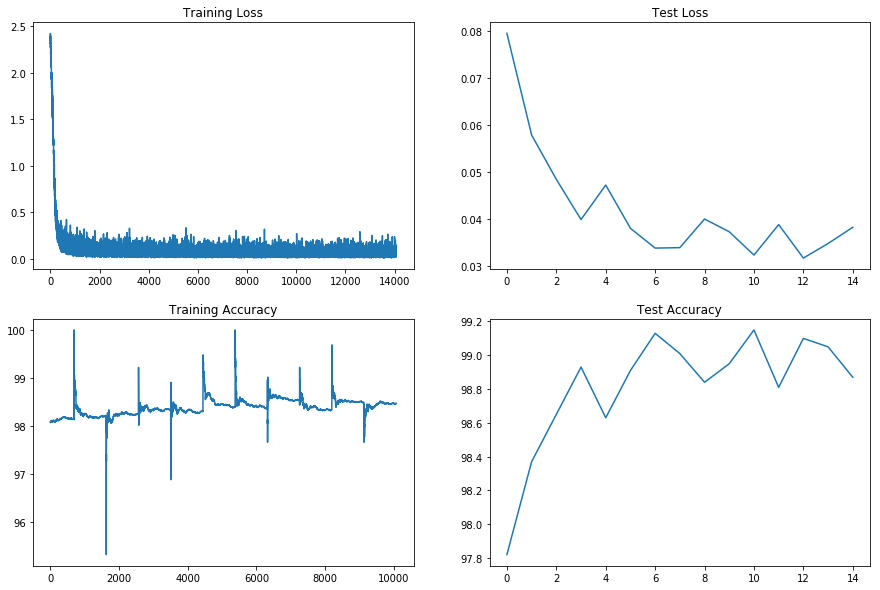

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.00001

In [10]:
l2_weight_decay = 0.0001

In [11]:
dropout_value = 0.1
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model4 = Net4().to(device)
summary(model4, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model4 =  Net4().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model4, device, train_loader, optimizer, epoch)
    test(model4, device, test_loader)

EPOCH: 0


Loss=0.05939284712076187 Batch_id=937 Accuracy=87.17: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.50it/s]



Test set: Average loss: 0.0765, Accuracy: 9781/10000 (97.81%)

EPOCH: 1


Loss=0.12983334064483643 Batch_id=937 Accuracy=97.38: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.81it/s]



Test set: Average loss: 0.0604, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.22613756358623505 Batch_id=937 Accuracy=97.80: 100%|██████████████████████████| 938/938 [00:17<00:00, 55.02it/s]



Test set: Average loss: 0.0423, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.01611541211605072 Batch_id=937 Accuracy=98.12: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.29it/s]



Test set: Average loss: 0.0358, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.03744658827781677 Batch_id=937 Accuracy=98.25: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.50it/s]



Test set: Average loss: 0.0452, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.012276872992515564 Batch_id=937 Accuracy=98.35: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.86it/s]



Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.013288602232933044 Batch_id=937 Accuracy=98.41: 100%|█████████████████████████| 938/938 [00:17<00:00, 60.30it/s]



Test set: Average loss: 0.0339, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.11146531999111176 Batch_id=937 Accuracy=98.52: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.41it/s]



Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.0976128876209259 Batch_id=937 Accuracy=98.54: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.70it/s]



Test set: Average loss: 0.0327, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.025907129049301147 Batch_id=937 Accuracy=98.56: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.55it/s]



Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.030208319425582886 Batch_id=937 Accuracy=98.68: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.96it/s]



Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.006178557872772217 Batch_id=937 Accuracy=98.75: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.95it/s]



Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.13437888026237488 Batch_id=937 Accuracy=98.66: 100%|██████████████████████████| 938/938 [00:17<00:00, 61.50it/s]



Test set: Average loss: 0.0245, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.07985212653875351 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.19it/s]



Test set: Average loss: 0.0243, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.07174322009086609 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.59it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

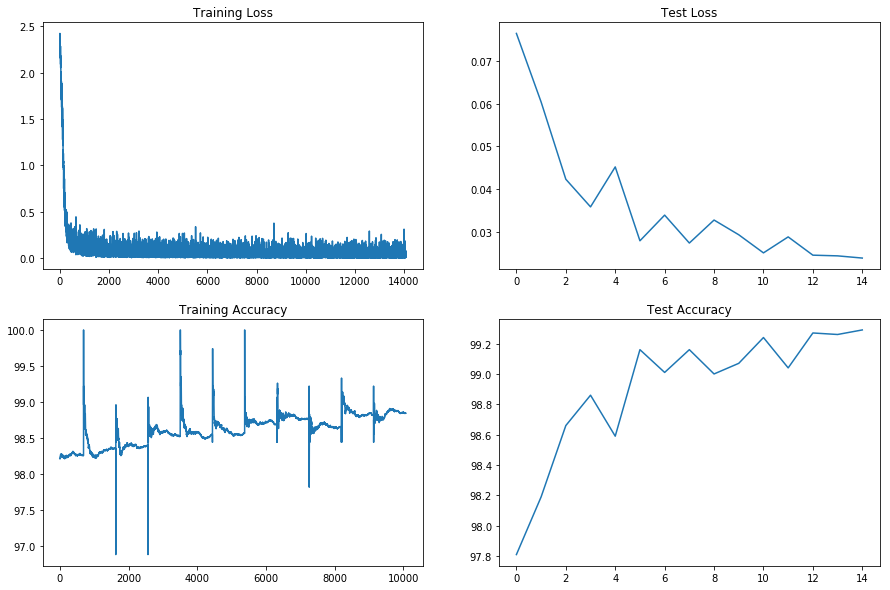

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.000001 #as if l1 absent

In [10]:
l2_weight_decay = 0.00001

In [11]:
dropout_value = 0.1
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model5 = Net5().to(device)
summary(model5, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model5 =  Net5().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model5, device, train_loader, optimizer, epoch)
    test(model5, device, test_loader)

EPOCH: 0


Loss=0.07169122248888016 Batch_id=937 Accuracy=87.18: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.12it/s]



Test set: Average loss: 0.0731, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.11511874198913574 Batch_id=937 Accuracy=97.40: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.02it/s]



Test set: Average loss: 0.0639, Accuracy: 9815/10000 (98.15%)

EPOCH: 2


Loss=0.2475273609161377 Batch_id=937 Accuracy=97.88: 100%|███████████████████████████| 938/938 [00:17<00:00, 54.84it/s]



Test set: Average loss: 0.0407, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.00802941620349884 Batch_id=937 Accuracy=98.19: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.71it/s]



Test set: Average loss: 0.0322, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.05244937539100647 Batch_id=937 Accuracy=98.26: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.66it/s]



Test set: Average loss: 0.0474, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


Loss=0.03165328502655029 Batch_id=937 Accuracy=98.39: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.96it/s]



Test set: Average loss: 0.0271, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.02153030037879944 Batch_id=937 Accuracy=98.51: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.58it/s]



Test set: Average loss: 0.0309, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.1272980272769928 Batch_id=937 Accuracy=98.56: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.98it/s]



Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.08540663123130798 Batch_id=937 Accuracy=98.59: 100%|██████████████████████████| 938/938 [00:17<00:00, 59.22it/s]



Test set: Average loss: 0.0336, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.023561537265777588 Batch_id=937 Accuracy=98.70: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.85it/s]



Test set: Average loss: 0.0270, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.01886698603630066 Batch_id=937 Accuracy=98.66: 100%|██████████████████████████| 938/938 [00:15<00:00, 58.72it/s]



Test set: Average loss: 0.0231, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.0060707926750183105 Batch_id=937 Accuracy=98.79: 100%|████████████████████████| 938/938 [00:17<00:00, 53.91it/s]



Test set: Average loss: 0.0299, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.10623282194137573 Batch_id=937 Accuracy=98.69: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.70it/s]



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.0796065703034401 Batch_id=937 Accuracy=98.90: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.38it/s]



Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.05428287386894226 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.00it/s]



Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

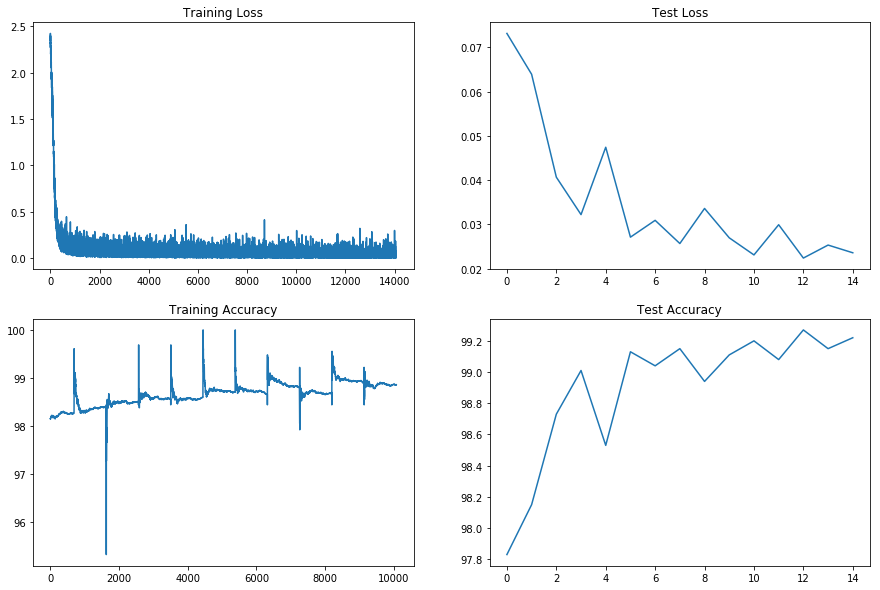

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.00005

In [10]:
l2_weight_decay = 0.000001

In [11]:
dropout_value = 0.1
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model6 = Net6().to(device)
summary(model6, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model6 =  Net6().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model6, device, train_loader, optimizer, epoch)
    test(model6, device, test_loader)

EPOCH: 0


Loss=0.05640793591737747 Batch_id=937 Accuracy=87.19: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.51it/s]



Test set: Average loss: 0.0739, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.12392255663871765 Batch_id=937 Accuracy=97.33: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.20it/s]



Test set: Average loss: 0.0667, Accuracy: 9801/10000 (98.01%)

EPOCH: 2


Loss=0.1757390946149826 Batch_id=937 Accuracy=97.81: 100%|███████████████████████████| 938/938 [00:18<00:00, 52.07it/s]



Test set: Average loss: 0.0400, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.012443050742149353 Batch_id=937 Accuracy=98.10: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.74it/s]



Test set: Average loss: 0.0346, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.03781144320964813 Batch_id=937 Accuracy=98.25: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.96it/s]



Test set: Average loss: 0.0435, Accuracy: 9868/10000 (98.68%)

EPOCH: 5


Loss=0.019690439105033875 Batch_id=937 Accuracy=98.36: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.24it/s]



Test set: Average loss: 0.0297, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.010666415095329285 Batch_id=937 Accuracy=98.47: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.14it/s]



Test set: Average loss: 0.0348, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.12233053892850876 Batch_id=937 Accuracy=98.54: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.15it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.0939372330904007 Batch_id=937 Accuracy=98.53: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.28it/s]



Test set: Average loss: 0.0360, Accuracy: 9890/10000 (98.90%)

EPOCH: 9


Loss=0.04459965229034424 Batch_id=937 Accuracy=98.66: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.39it/s]



Test set: Average loss: 0.0269, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.008170902729034424 Batch_id=937 Accuracy=98.64: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.20it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.009944677352905273 Batch_id=937 Accuracy=98.78: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.66it/s]



Test set: Average loss: 0.0325, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


Loss=0.08196984976530075 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.59it/s]



Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.09052057564258575 Batch_id=937 Accuracy=98.85: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.01it/s]



Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.07212363183498383 Batch_id=937 Accuracy=98.89: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.29it/s]



Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

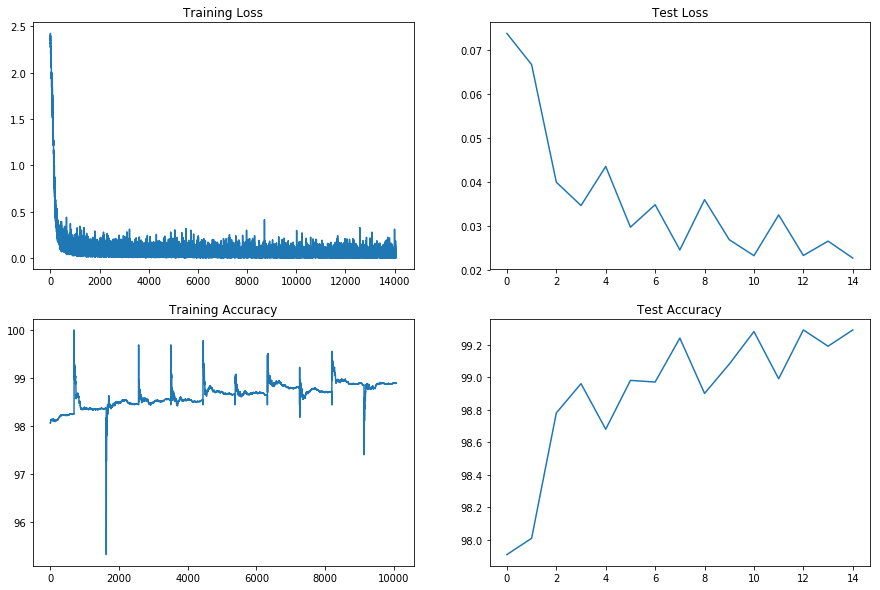

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.000025

In [10]:
l2_weight_decay = 0.0000001

In [11]:
dropout_value = 0.1
class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model7 = Net7().to(device)
summary(model7, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model7 =  Net7().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model7.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model7, device, train_loader, optimizer, epoch)
    test(model7, device, test_loader)

EPOCH: 0


Loss=0.054419003427028656 Batch_id=937 Accuracy=87.14: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.85it/s]



Test set: Average loss: 0.0827, Accuracy: 9766/10000 (97.66%)

EPOCH: 1


Loss=0.12908785045146942 Batch_id=937 Accuracy=97.39: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.09it/s]



Test set: Average loss: 0.0615, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.2471771091222763 Batch_id=937 Accuracy=97.88: 100%|███████████████████████████| 938/938 [00:18<00:00, 42.44it/s]



Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.01329582929611206 Batch_id=937 Accuracy=98.13: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.57it/s]



Test set: Average loss: 0.0332, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.03225232660770416 Batch_id=937 Accuracy=98.27: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.54it/s]



Test set: Average loss: 0.0419, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.017420440912246704 Batch_id=937 Accuracy=98.41: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.73it/s]



Test set: Average loss: 0.0273, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.029333069920539856 Batch_id=937 Accuracy=98.48: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.80it/s]



Test set: Average loss: 0.0317, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.15313413739204407 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.76it/s]



Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.08558832108974457 Batch_id=937 Accuracy=98.60: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.65it/s]



Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.020313411951065063 Batch_id=937 Accuracy=98.66: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.64it/s]



Test set: Average loss: 0.0255, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.014114663004875183 Batch_id=937 Accuracy=98.65: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.77it/s]



Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.00438612699508667 Batch_id=937 Accuracy=98.78: 100%|██████████████████████████| 938/938 [00:19<00:00, 47.29it/s]



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.0959310308098793 Batch_id=937 Accuracy=98.70: 100%|███████████████████████████| 938/938 [00:19<00:00, 47.20it/s]



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.06483782827854156 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.83it/s]



Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.03267115354537964 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.81it/s]



Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

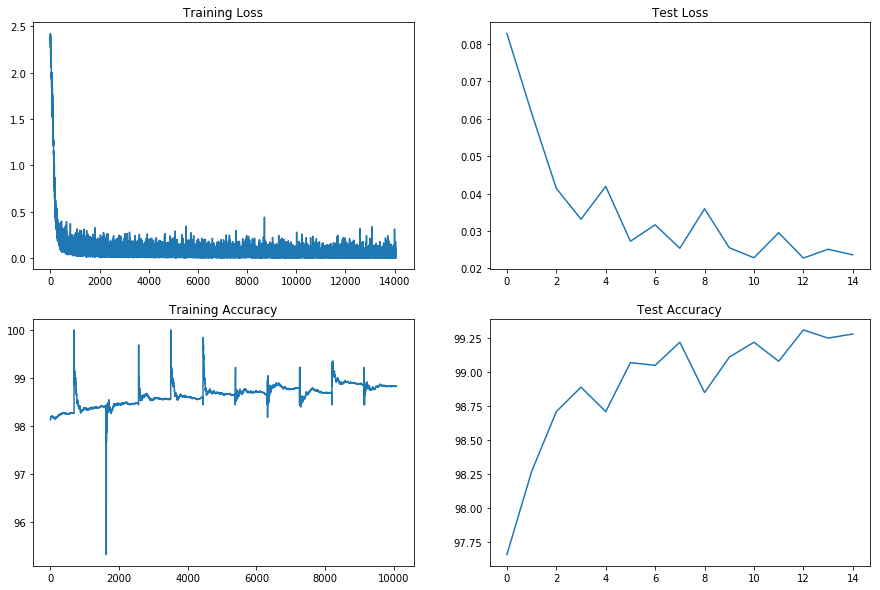

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.0000125

In [10]:
l2_weight_decay = 0.0005

In [11]:
dropout_value = 0.1
class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model8 = Net8().to(device)
summary(model8, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model8 =  Net8().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model8.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model8, device, train_loader, optimizer, epoch)
    test(model8, device, test_loader)

EPOCH: 0


Loss=0.05213520675897598 Batch_id=937 Accuracy=87.14: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.20it/s]



Test set: Average loss: 0.0740, Accuracy: 9795/10000 (97.95%)

EPOCH: 1


Loss=0.13941329717636108 Batch_id=937 Accuracy=97.37: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.68it/s]



Test set: Average loss: 0.0593, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.29088541865348816 Batch_id=937 Accuracy=97.81: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.56it/s]



Test set: Average loss: 0.0433, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.018570885062217712 Batch_id=937 Accuracy=98.08: 100%|█████████████████████████| 938/938 [00:20<00:00, 45.27it/s]



Test set: Average loss: 0.0333, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.058638185262680054 Batch_id=937 Accuracy=98.23: 100%|█████████████████████████| 938/938 [00:19<00:00, 47.27it/s]



Test set: Average loss: 0.0466, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


Loss=0.02443815767765045 Batch_id=937 Accuracy=98.30: 100%|██████████████████████████| 938/938 [00:21<00:00, 42.65it/s]



Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.0339093953371048 Batch_id=937 Accuracy=98.43: 100%|███████████████████████████| 938/938 [00:18<00:00, 49.51it/s]



Test set: Average loss: 0.0289, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.12168940156698227 Batch_id=937 Accuracy=98.43: 100%|██████████████████████████| 938/938 [00:19<00:00, 63.97it/s]



Test set: Average loss: 0.0302, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.19199082255363464 Batch_id=937 Accuracy=98.47: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.37it/s]



Test set: Average loss: 0.0353, Accuracy: 9888/10000 (98.88%)

EPOCH: 9


Loss=0.012592405080795288 Batch_id=937 Accuracy=98.52: 100%|█████████████████████████| 938/938 [00:21<00:00, 43.90it/s]



Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.04234719276428223 Batch_id=937 Accuracy=98.54: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.75it/s]



Test set: Average loss: 0.0285, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.020351499319076538 Batch_id=937 Accuracy=98.64: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.51it/s]



Test set: Average loss: 0.0374, Accuracy: 9883/10000 (98.83%)

EPOCH: 12


Loss=0.07426421344280243 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:20<00:00, 46.78it/s]



Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.04784934222698212 Batch_id=937 Accuracy=98.64: 100%|██████████████████████████| 938/938 [00:19<00:00, 48.22it/s]



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.10604274272918701 Batch_id=937 Accuracy=98.68: 100%|██████████████████████████| 938/938 [00:19<00:00, 48.72it/s]



Test set: Average loss: 0.0241, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

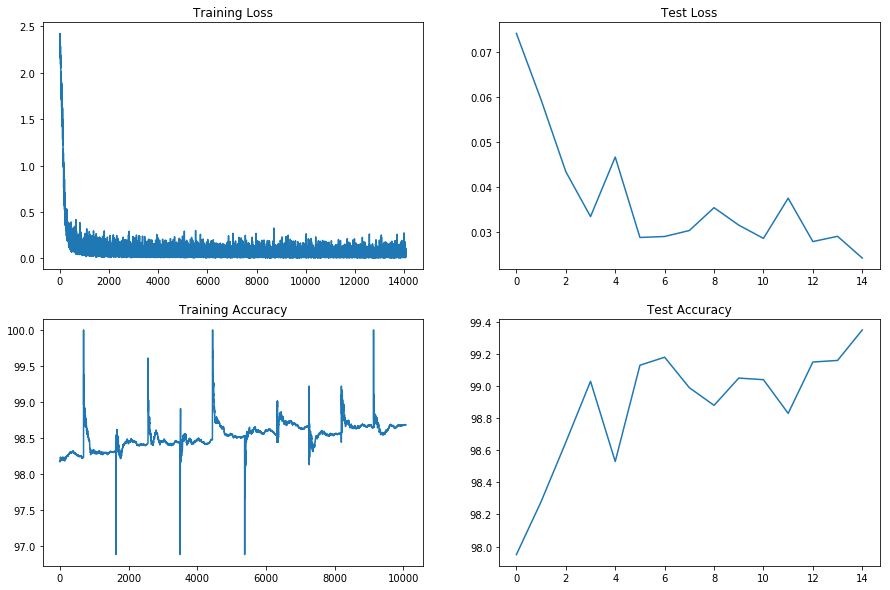

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
l1_weight = 0.0000375

In [16]:
l2_weight_decay = 0.00025

In [17]:
dropout_value = 0.1
class Net9(nn.Module):
    def __init__(self):
        super(Net9, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [18]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model9 = Net9().to(device)
summary(model9, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
model9 =  Net9().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model9, device, train_loader, optimizer, epoch)
    test(model9, device, test_loader)

EPOCH: 0


Loss=0.19277416169643402 Batch_id=937 Accuracy=87.35: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.05it/s]



Test set: Average loss: 0.0540, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.020469099283218384 Batch_id=937 Accuracy=97.34: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.67it/s]



Test set: Average loss: 0.0412, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.2425866276025772 Batch_id=937 Accuracy=97.83: 100%|███████████████████████████| 938/938 [00:17<00:00, 54.30it/s]



Test set: Average loss: 0.0339, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.01849997043609619 Batch_id=937 Accuracy=98.15: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.69it/s]



Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.06234809011220932 Batch_id=937 Accuracy=98.28: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.94it/s]



Test set: Average loss: 0.0291, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.014977306127548218 Batch_id=937 Accuracy=98.41: 100%|█████████████████████████| 938/938 [00:16<00:00, 61.34it/s]



Test set: Average loss: 0.0295, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.24390645325183868 Batch_id=937 Accuracy=98.43: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.64it/s]



Test set: Average loss: 0.0269, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.057129792869091034 Batch_id=937 Accuracy=98.55: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.84it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.006773918867111206 Batch_id=937 Accuracy=98.53: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.34it/s]



Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.014640450477600098 Batch_id=937 Accuracy=98.61: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.37it/s]



Test set: Average loss: 0.0254, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.016389116644859314 Batch_id=937 Accuracy=98.68: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.42it/s]



Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.0831148773431778 Batch_id=937 Accuracy=98.78: 100%|███████████████████████████| 938/938 [00:17<00:00, 64.75it/s]



Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.01094105839729309 Batch_id=937 Accuracy=98.69: 100%|██████████████████████████| 938/938 [00:19<00:00, 46.93it/s]



Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.020313158631324768 Batch_id=937 Accuracy=98.80: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.15it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.2066560834646225 Batch_id=937 Accuracy=98.80: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.94it/s]



Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

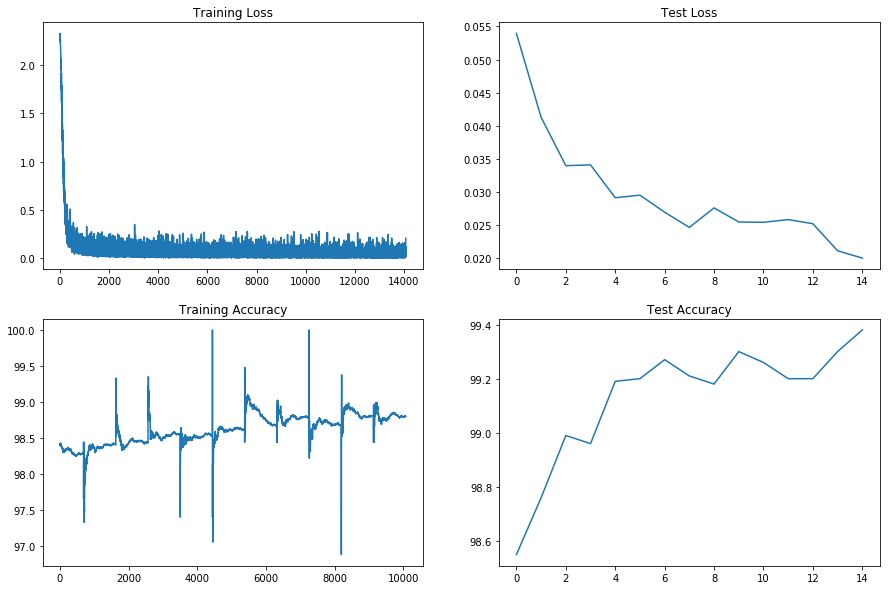

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.00003125

In [10]:
l2_weight_decay = 0.000375

In [11]:
dropout_value = 0.1
class Net10(nn.Module):
    def __init__(self):
        super(Net10, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model10 = Net10().to(device)
summary(model10, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model10 =  Net10().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model10.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model10, device, train_loader, optimizer, epoch)
    test(model10, device, test_loader)

EPOCH: 0


Loss=0.065741628408432 Batch_id=937 Accuracy=87.17: 100%|████████████████████████████| 938/938 [00:17<00:00, 53.61it/s]



Test set: Average loss: 0.0743, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.14910613000392914 Batch_id=937 Accuracy=97.43: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.23it/s]



Test set: Average loss: 0.0609, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.23041243851184845 Batch_id=937 Accuracy=97.81: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.32it/s]



Test set: Average loss: 0.0439, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.018359839916229248 Batch_id=937 Accuracy=98.14: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.75it/s]



Test set: Average loss: 0.0329, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.046636566519737244 Batch_id=937 Accuracy=98.24: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.09it/s]



Test set: Average loss: 0.0419, Accuracy: 9868/10000 (98.68%)

EPOCH: 5


Loss=0.02896741032600403 Batch_id=937 Accuracy=98.33: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.27it/s]



Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.027140989899635315 Batch_id=937 Accuracy=98.40: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.88it/s]



Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.13066543638706207 Batch_id=937 Accuracy=98.43: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.21it/s]



Test set: Average loss: 0.0298, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.1495593935251236 Batch_id=937 Accuracy=98.44: 100%|███████████████████████████| 938/938 [00:21<00:00, 43.82it/s]



Test set: Average loss: 0.0378, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.0168582946062088 Batch_id=937 Accuracy=98.58: 100%|███████████████████████████| 938/938 [00:46<00:00, 20.18it/s]



Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.03395022451877594 Batch_id=937 Accuracy=98.57: 100%|██████████████████████████| 938/938 [00:47<00:00, 15.29it/s]



Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.011893436312675476 Batch_id=937 Accuracy=98.65: 100%|█████████████████████████| 938/938 [00:46<00:00, 29.58it/s]



Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.10706476122140884 Batch_id=937 Accuracy=98.63: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.74it/s]



Test set: Average loss: 0.0275, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.04765715450048447 Batch_id=937 Accuracy=98.71: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.31it/s]



Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=0.12312997877597809 Batch_id=937 Accuracy=98.70: 100%|██████████████████████████| 938/938 [00:20<00:00, 66.27it/s]



Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)



Text(0.5, 1.0, 'Test Accuracy')

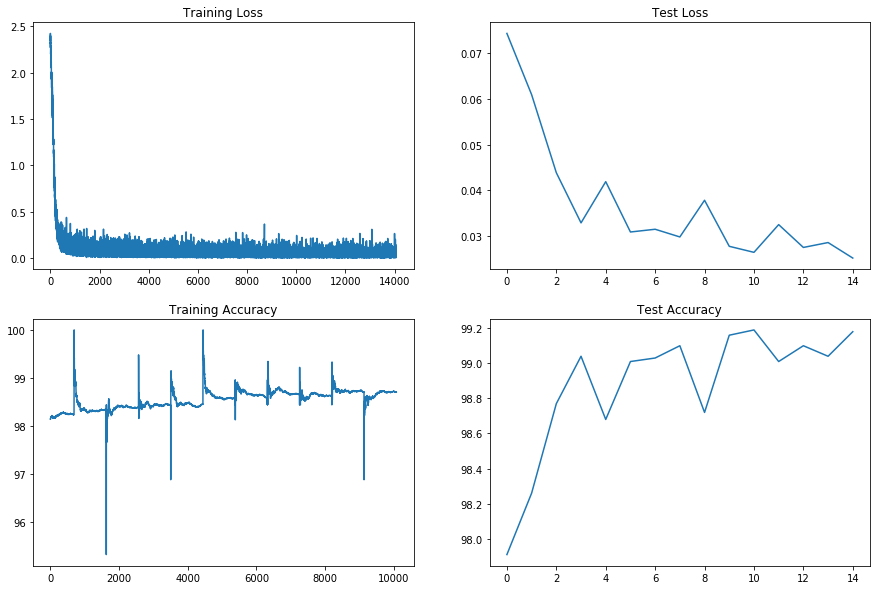

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.0000255

In [10]:
l2_weight_decay = 0.000175

In [11]:
dropout_value = 0.1
class Net11(nn.Module):
    def __init__(self):
        super(Net11, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model11 = Net11().to(device)
summary(model11, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model11 =  Net11().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model11.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model11, device, train_loader, optimizer, epoch)
    test(model11, device, test_loader)

EPOCH: 0


Loss=0.055888161063194275 Batch_id=937 Accuracy=87.19: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.25it/s]



Test set: Average loss: 0.0763, Accuracy: 9779/10000 (97.79%)

EPOCH: 1


Loss=0.10616018623113632 Batch_id=937 Accuracy=97.39: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.61it/s]



Test set: Average loss: 0.0678, Accuracy: 9814/10000 (98.14%)

EPOCH: 2


Loss=0.20237524807453156 Batch_id=937 Accuracy=97.86: 100%|██████████████████████████| 938/938 [00:17<00:00, 67.53it/s]



Test set: Average loss: 0.0400, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.016746729612350464 Batch_id=937 Accuracy=98.10: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.53it/s]



Test set: Average loss: 0.0357, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.03228488564491272 Batch_id=937 Accuracy=98.30: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.10it/s]



Test set: Average loss: 0.0499, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.011418476700782776 Batch_id=937 Accuracy=98.37: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.19it/s]



Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.028916269540786743 Batch_id=937 Accuracy=98.44: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.61it/s]



Test set: Average loss: 0.0312, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.14975669980049133 Batch_id=937 Accuracy=98.47: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.11it/s]



Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.13229863345623016 Batch_id=937 Accuracy=98.48: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.05it/s]



Test set: Average loss: 0.0326, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.018506959080696106 Batch_id=937 Accuracy=98.63: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.55it/s]



Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.01802082359790802 Batch_id=937 Accuracy=98.61: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.56it/s]



Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.014585629105567932 Batch_id=937 Accuracy=98.73: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.45it/s]



Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.1148078665137291 Batch_id=937 Accuracy=98.66: 100%|███████████████████████████| 938/938 [00:17<00:00, 62.51it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.06761299073696136 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.18it/s]



Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.08399444818496704 Batch_id=937 Accuracy=98.75: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.23it/s]



Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

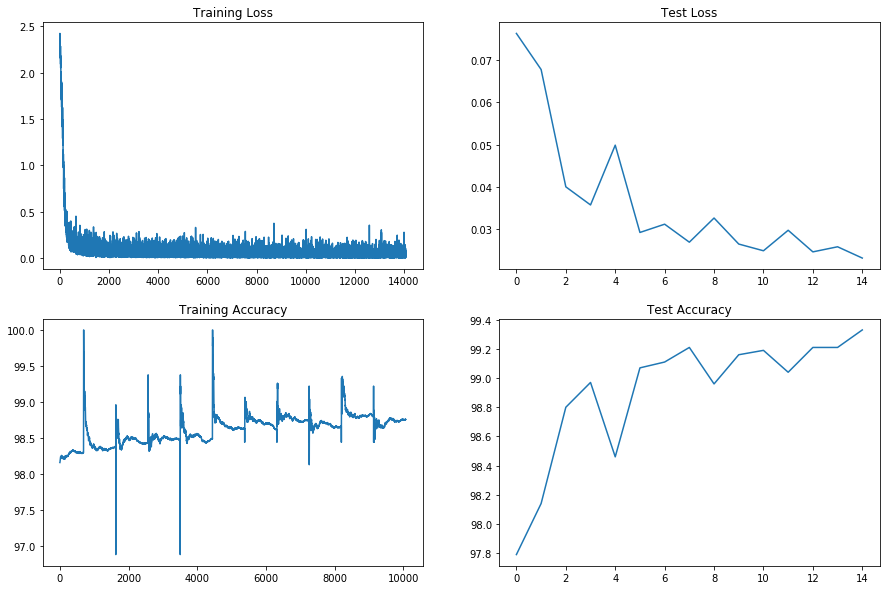

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
l1_weight = 0.000025

In [10]:
l2_weight_decay = 0.0002125 ##Appears to be the best with the reference NW we have used here

In [11]:
dropout_value = 0.1
class Net12(nn.Module):
    def __init__(self):
        super(Net12, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model12 = Net12().to(device)
summary(model12, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
model12 =  Net12().to(device)
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model12.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model12, device, train_loader, optimizer, epoch)
    test(model12, device, test_loader)

EPOCH: 0


Loss=0.18824279308319092 Batch_id=937 Accuracy=87.35: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.58it/s]



Test set: Average loss: 0.0563, Accuracy: 9845/10000 (98.45%)

EPOCH: 1


Loss=0.02295863628387451 Batch_id=937 Accuracy=97.35: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.58it/s]



Test set: Average loss: 0.0407, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.20344741642475128 Batch_id=937 Accuracy=97.89: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.68it/s]



Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.01783469319343567 Batch_id=937 Accuracy=98.07: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.88it/s]



Test set: Average loss: 0.0316, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.0777805969119072 Batch_id=937 Accuracy=98.33: 100%|███████████████████████████| 938/938 [00:16<00:00, 56.29it/s]



Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.005782723426818848 Batch_id=937 Accuracy=98.43: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.95it/s]



Test set: Average loss: 0.0277, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.1524503529071808 Batch_id=937 Accuracy=98.56: 100%|███████████████████████████| 938/938 [00:16<00:00, 55.28it/s]



Test set: Average loss: 0.0266, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.07780013233423233 Batch_id=937 Accuracy=98.54: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.54it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.004843920469284058 Batch_id=937 Accuracy=98.58: 100%|█████████████████████████| 938/938 [00:17<00:00, 70.26it/s]



Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.024917826056480408 Batch_id=937 Accuracy=98.63: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.56it/s]



Test set: Average loss: 0.0269, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.01141446828842163 Batch_id=937 Accuracy=98.68: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.98it/s]



Test set: Average loss: 0.0263, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.1196247786283493 Batch_id=937 Accuracy=98.73: 100%|███████████████████████████| 938/938 [00:18<00:00, 49.71it/s]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.017878994345664978 Batch_id=937 Accuracy=98.70: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.71it/s]



Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.026755258440971375 Batch_id=937 Accuracy=98.81: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.90it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.16907355189323425 Batch_id=937 Accuracy=98.78: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.82it/s]



Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.04229794442653656 Batch_id=937 Accuracy=98.82: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.14it/s]



Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99.18%)

EPOCH: 16


Loss=0.00214250385761261 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.67it/s]



Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.07006824761629105 Batch_id=937 Accuracy=98.82: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.07it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.030049964785575867 Batch_id=937 Accuracy=98.88: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.62it/s]



Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.02165430784225464 Batch_id=937 Accuracy=98.85: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.34it/s]



Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.032213687896728516 Batch_id=937 Accuracy=98.89: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.65it/s]



Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.01030847430229187 Batch_id=937 Accuracy=98.91: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.71it/s]



Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 22


Loss=0.0037942826747894287 Batch_id=937 Accuracy=98.90: 100%|████████████████████████| 938/938 [00:18<00:00, 51.18it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.07014226913452148 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.47it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.027967147529125214 Batch_id=937 Accuracy=98.97: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.61it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 25


Loss=0.007446184754371643 Batch_id=937 Accuracy=98.87: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.36it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


Loss=0.12884274125099182 Batch_id=937 Accuracy=98.97: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.29it/s]



Test set: Average loss: 0.0182, Accuracy: 9938/10000 (99.38%)

EPOCH: 27


Loss=0.03166118264198303 Batch_id=937 Accuracy=98.91: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.98it/s]



Test set: Average loss: 0.0231, Accuracy: 9936/10000 (99.36%)

EPOCH: 28


Loss=0.008750185370445251 Batch_id=937 Accuracy=98.95: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.25it/s]



Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 29


Loss=0.005977511405944824 Batch_id=937 Accuracy=98.90: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.65it/s]



Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.03337831050157547 Batch_id=937 Accuracy=98.92: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.48it/s]



Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 31


Loss=0.04734387993812561 Batch_id=937 Accuracy=98.92: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.62it/s]



Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.010173708200454712 Batch_id=937 Accuracy=98.92: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.26it/s]



Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.07469946891069412 Batch_id=937 Accuracy=98.94: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.49it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.06654493510723114 Batch_id=937 Accuracy=98.99: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.38it/s]



Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.09035762399435043 Batch_id=937 Accuracy=98.98: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.22it/s]



Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.00795002281665802 Batch_id=937 Accuracy=99.02: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.00it/s]



Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.08107984066009521 Batch_id=937 Accuracy=98.92: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.22it/s]



Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

EPOCH: 38


Loss=0.03131110966205597 Batch_id=937 Accuracy=98.97: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.13it/s]



Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.007167935371398926 Batch_id=937 Accuracy=99.00: 100%|█████████████████████████| 938/938 [00:18<00:00, 49.72it/s]



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

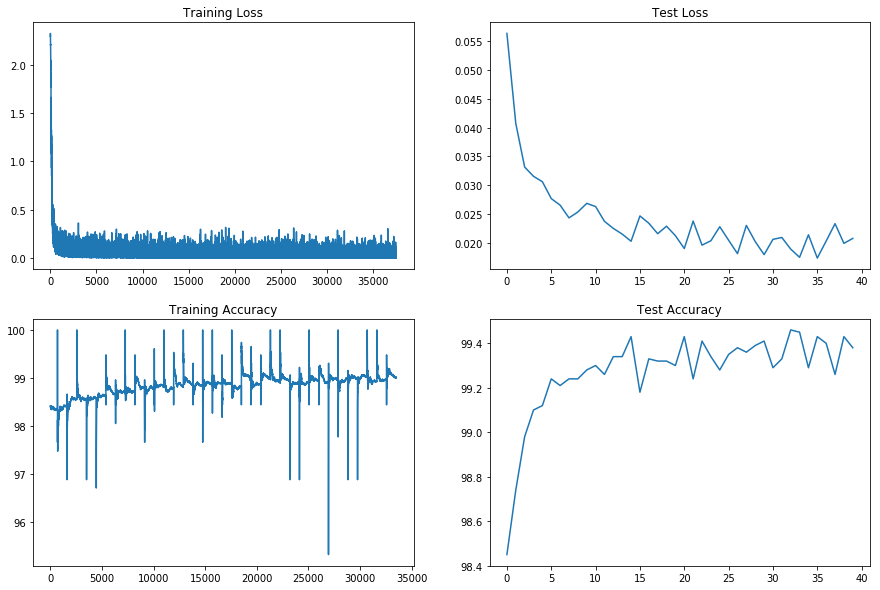

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
import os

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'MNIST_model_with_L1.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
torch.save(model12, filepath)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net12. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
import os
import numpy as np
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_data')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath_test_loss_with_l1 = os.path.join(save_dir, 'test_loss_with_l1.npy')
filepath_test_acc_with_l1 = os.path.join(save_dir, 'test_acc_with_l1.npy')
np.save(filepath_test_loss_with_l1,test_losses)
np.save(filepath_test_acc_with_l1,test_acc)

In [29]:
loaded_test_losses_with_l1 =  np.load(filepath_test_loss_with_l1).tolist()
loaded_test_acc_with_l1 =  np.load(filepath_test_acc_with_l1).tolist()

Text(0.5, 1.0, 'Test Accuracy')

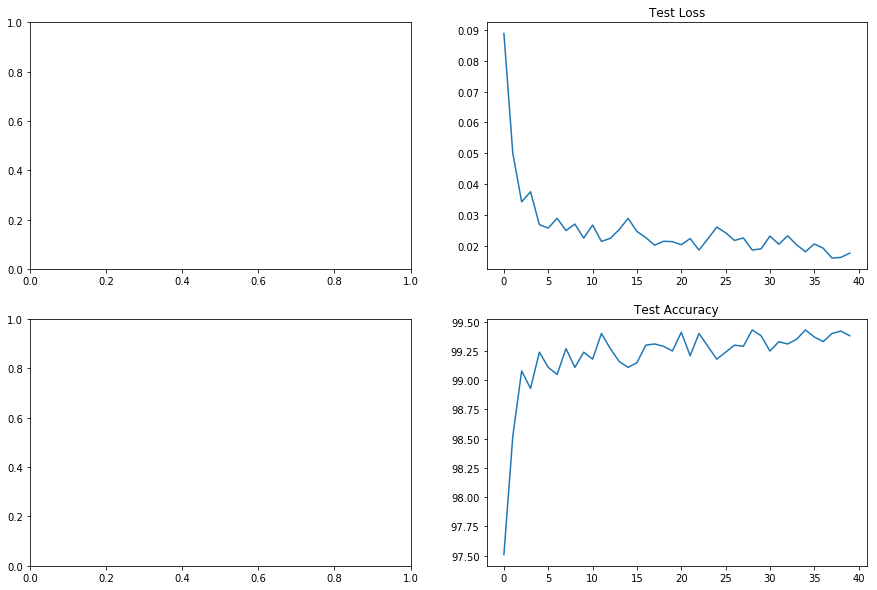

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 1].plot(loaded_test_losses_with_l1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(loaded_test_acc_with_l1)
axs[1, 1].set_title("Test Accuracy")

In [15]:
the_model = torch.load(filepath)

In [16]:
the_model.to(device)
optimizer = optim.SGD(the_model.parameters(), lr=0.01, momentum=0.9)
test_losses = []
test_acc = []
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    test(the_model, device, test_loader)

EPOCH: 0

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 1

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 2

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 3

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 4

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 5

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 6

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 7

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 8

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 9

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 10

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 11

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 12

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 13

Test set: Average loss: 0.0186, Accur

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
_= axs[0].plot(acc_history)
_= axs[0].plot(val_acc_history)
_= axs[0].set_title('model accuracy')
_= axs[0].set_ylabel('accuracy')
_= axs[0].set_xlabel('epoch')
_= axs[0].legend(['train', 'val'], loc='upper left')
_= axs[1].plot(loss_history)
_= axs[1].plot(val_loss_history)
_= axs[1].set_title('model loss')
_= axs[1].set_ylabel('loss')
_= axs[1].set_xlabel('epoch')
_= axs[1].legend(['train', 'val'], loc='upper left')

In [44]:
def model_pred(model, device, y_test, batchsize=test_mnist.test_data.cpu().numpy().shape[0]):
    from sklearn.metrics import confusion_matrix, classification_report
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_mnist, **dataldr_args)
    with torch.no_grad():
        for data, target in test_ldr:
            data, target = data.to(device), target.to(device)
            output = model12(data)
            y_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred = y_pred.cpu().numpy()
    print(confusion_matrix(y_test, y_pred.reshape(-1)))
    print('\n')
    print(classification_report(y_test, y_pred.reshape(-1), target_names=class_names))
    return y_pred

In [45]:
def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

In [46]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model12, device, y_test)

[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1128    3    3    0    0    1    0    0    0]
 [   0    2 1012    5    0    0    3    7    3    0]
 [   0    0    2  998    0    2    0    6    1    1]
 [   1    0    0    0  969    0    2    0    0   10]
 [   1    0    0   11    0  871    6    1    0    2]
 [   2    6    1    0    4    2  943    0    0    0]
 [   0    6    9    0    0    1    0 1011    0    1]
 [   2    1    2    1    6    4    1    2  947    8]
 [   4    2    0    0    6    0    0   11    0  986]]


              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       980
         one       0.98      0.99      0.99      1135
         two       0.98      0.98      0.98      1032
       three       0.98      0.99      0.98      1010
        four       0.98      0.99      0.99       982
        five       0.99      0.98      0.98       892
         six       0.99      0.98      0.98       958
       seven       0.97      0.98 

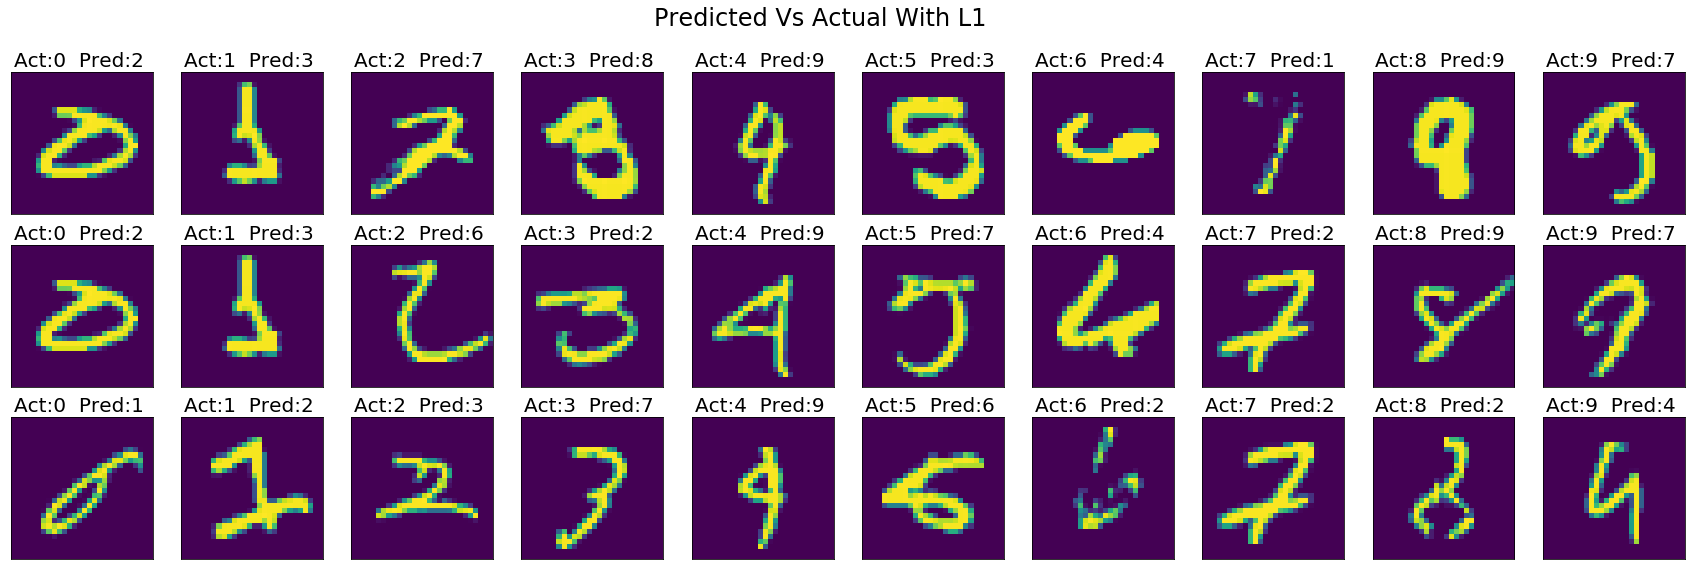

In [47]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model12, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With L1' )